In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

In [6]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["date"])
df

,tmax,date,prcp,snow,humidity,precipitation,precip_probability,precip_type,wind_speed,wind_direction,...,nasa_temp_min_rolling_mean7,nasa_temp_min_rolling_std7,nasa_temp_min_rolling_mean14,nasa_temp_min_rolling_std14,nasa_temp_min_rolling_mean30,nasa_temp_min_rolling_std30,day,dayofyear,dayofweek,season
0,39.02,2015-01-01,0.00,0.0,37.9,0.000,0.0,NaN,11.4,250.2,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3,Winter
1,39.56,2015-01-02,0.00,0.0,40.7,0.000,0.0,NaN,15.1,270.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,Winter
2,39.56,2015-01-03,0.71,0.0,67.9,0.670,100.0,"['rain', 'snow']",9.2,71.1,...,NaN,NaN,NaN,NaN,NaN,NaN,3,3,5,Winter
3,42.08,2015-01-04,0.30,0.0,86.7,0.351,100.0,['rain'],13.9,246.7,...,NaN,NaN,NaN,NaN,NaN,NaN,4,4,6,Winter
4,40.82,2015-01-05,0.00,0.0,36.3,0.000,0.0,NaN,22.8,290.8,...,NaN,NaN,NaN,NaN,NaN,NaN,5,5,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,41.00,2023-12-27,0.32,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.780000,3.775160,-0.570000,3.285525,-0.273000,3.290928,27,361,2,Winter
3283,41.90,2023-12-28,1.22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.481429,4.003804,-0.082143,3.558957,-0.120667,3.421544,28,362,3,Winter
3284,41.90,2023-12-29,0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.112857,4.047706,0.677857,3.884884,0.200000,3.633173,29,363,4,Winter
3285,40.28,2023-12-30,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.327143,2.662816,1.047143,3.909630,0.429333,3.628948,30,364,5,Winter


In [1]:
#Select features and target
drop_cols = ['precip_type', 'season']
X = df.drop(columns=drop_cols + ['tmax'], errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df['tmax']

#Impute & scale
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

#Split data (preserve time order)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)
test_dates = y.index[-len(y_test):]

#Define parameter grid and time series CV
param_grid = {
    'n_neighbors': list(range(3, 16)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
tscv = TimeSeriesSplit(n_splits=5)

#Grid search
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

#Predict with best model
y_pred = best_model.predict(X_test)

#Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Best Parameters ===")
print(grid_search.best_params_)
print("\n=== Evaluation on Test Set ===")
print(f"RMSE: {rmse:.2f} °F")
print(f"MAE : {mae:.2f} °F")
print(f"R²  : {r2:.3f}")


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['ms_wind_gust']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Fitting 5 folds for each of 52 candidates, totalling 260 fits
=== Best Parameters ===
{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}

=== Evaluation on Test Set ===
RMSE: 1.20 °F
MAE : 0.94 °F
R²  : 0.818


In [11]:
used_feature_names = X.columns.tolist()
print(f"Total Features number{len(used_feature_names)} ：\n")
for i, feat in enumerate(used_feature_names, 1):
    print(f"{i:3d}. {feat}")


Total Features number154 ：

  1. prcp
  2. snow
  3. humidity
  4. precipitation
  5. precip_probability
  6. wind_speed
  7. wind_direction
  8. pressure
  9. cloud_cover
 10. visibility
 11. uv_index
 12. albedo
 13. vegetation_index
 14. tree_canopy_percent
 15. impervious_surface_percent
 16. building_density
 17. water_surface_percent
 18. distance_to_water_km
 19. heatmap_intensity
 20. nasa_humidity
 21. nasa_precipitation
 22. nasa_wind_speed
 23. solar_radiation
 24. longwave_radiation
 25. ms_precipitation
 26. ms_snow
 27. ms_wind_direction
 28. ms_wind_speed
 29. ms_wind_gust
 30. ms_pressure
 31. ms_sunshine
 32. is_holiday
 33. is_weekend
 34. day_of_week
 35. day_of_year
 36. week_of_year
 37. month
 38. year
 39. carbon_monoxide
 40. ozone
 41. pm25
 42. tmin_lag1
 43. tmin_lag3
 44. tmin_lag7
 45. tmin_lag14
 46. tmin_lag30
 47. tmin_rolling_mean7
 48. tmin_rolling_std7
 49. tmin_rolling_mean14
 50. tmin_rolling_std14
 51. tmin_rolling_mean30
 52. tmin_rolling_std30
 5

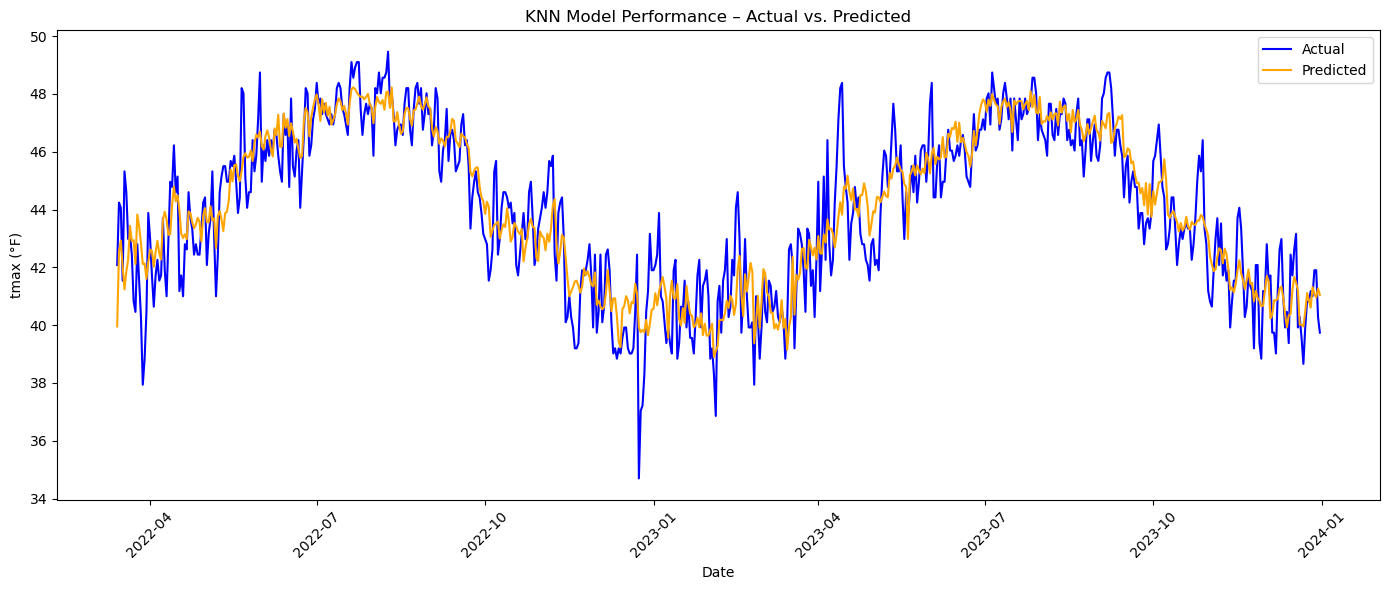

In [5]:
#Plot
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test.values, label="Actual", color='blue')
plt.plot(test_dates, y_pred, label="Predicted", color='orange')
plt.title("KNN Model Performance – Actual vs. Predicted")
plt.xlabel("Date")
plt.ylabel("tmax (°F)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("knn_actual_vs_predicted.png", dpi=300)
plt.show()


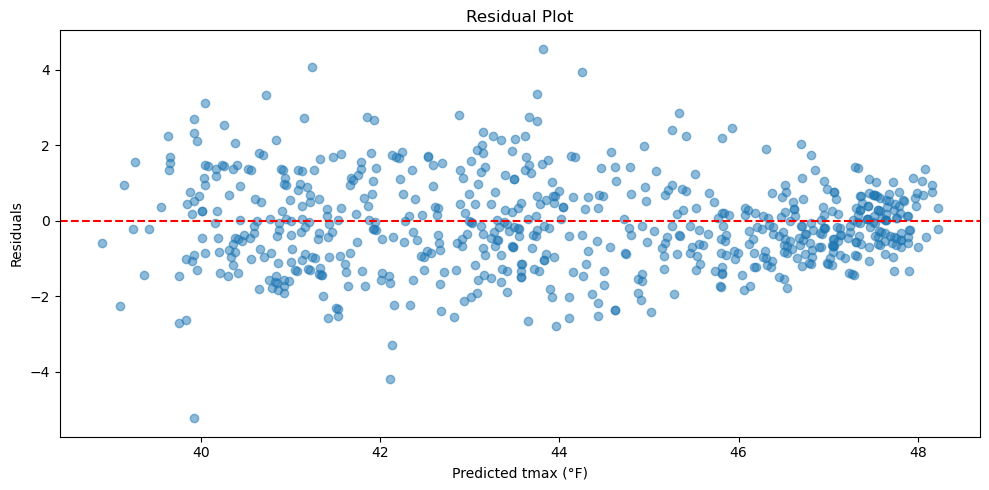

In [6]:
residuals = y_test.values - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted tmax (°F)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.savefig("knn_residuals.png", dpi=300)
plt.show()


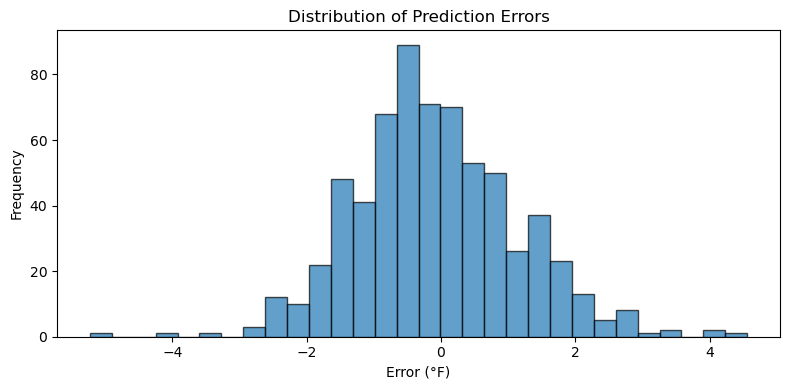

In [9]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("knn_error_distribution.png", dpi=300)
plt.show()


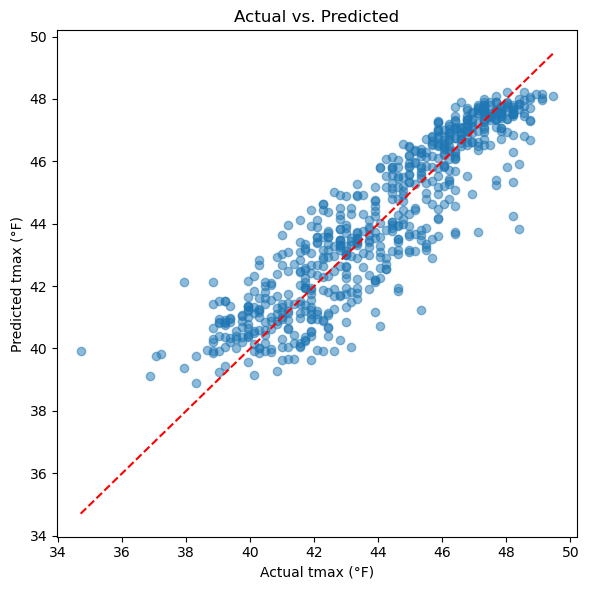

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual tmax (°F)")
plt.ylabel("Predicted tmax (°F)")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.savefig("knn_actual_vs_predicted_scatter.png", dpi=300)
plt.show()
